<a href="https://colab.research.google.com/github/Ark1645/Deep-Learning/blob/main/CBAM_on_BNN_on_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Input,MaxPooling2D
from tensorflow.keras.layers import Activation, Concatenate, Conv2D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from visualize import plotImages, plotHistory, explainGradCam
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal',
                              use_bias=True,
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)


            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)

            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
img_width, img_height, img_num_channels = 32, 32, 3

In [ ]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size

        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):

            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)

            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

In [ ]:
def cbam(x,ratio=12):
    x = ChannelAttention(x,ratio)
    x = SpatialAttention(x)
    return x

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar100',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteXD4XKF/cifar100-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar100/3.0.2.incompleteXD4XKF/cifar100-test.tfrecord*...:   0%|         …

Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpzeqqd4gptfds'),
    file_format=tfrecord,
    download_size=160.71 MiB,
    dataset_size=132.03 MiB,
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=int64, num_classes=20),
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=100),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [ ]:
ds_info.features['label'].names

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

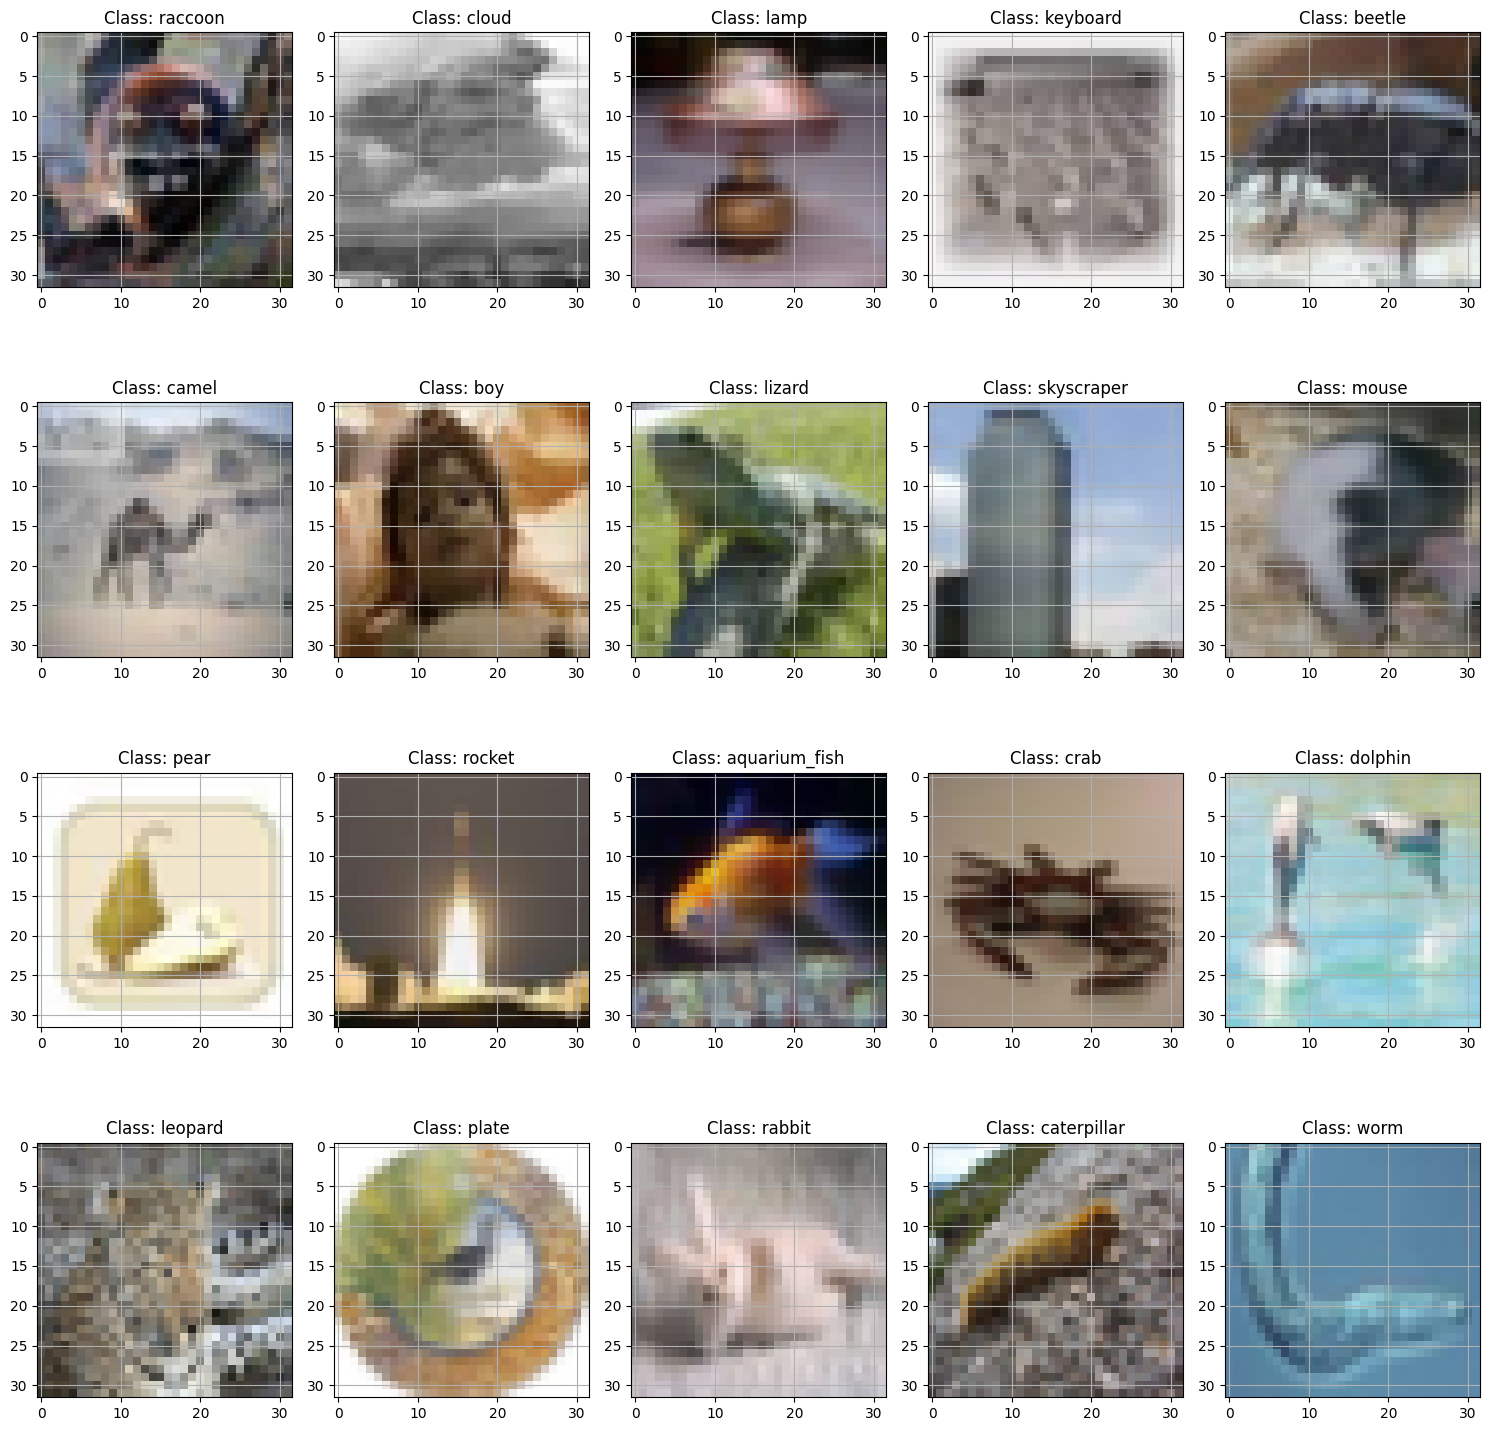

In [ ]:
for data in ds_train.batch(20):
    plotImages(data, 20, ds_info.features['label'].names)
    break

In [ ]:
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
ds_train = ds_train.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(32)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_test = ds_test.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Parse numbers as floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize data
X_train = (X_train) / 255.
X_test = (X_test) / 255.

# number of classes
nb_classes = len(np.unique(y_train))

# Image size
img_width, img_height, img_num_channels = 32, 32, 3
input_shape = (img_width, img_height, img_num_channels)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

169001437/169001437 [==============================] - 2s 0us/step


In [ ]:
def simple_cnn_no_attention():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(Activation('elu'))
  model.add(BatchNormalization())

  model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('elu'))
  model.add(Dropout(0.5))
  model.add(Dense(nb_classes))
  model.add(Activation('softmax'))
  return model

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 activation_72 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_48 (Ba  (None, 32, 32, 128)       512       
 tchNormalization)                                               
                                                                 
 dropout_36 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_50 (Conv2D)          (None, 30, 30, 128)       147584    
                                                                 
 activation_73 (Activation)  (None, 30, 30, 128)       0         
                                                     

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,  # Increased zoom range
    shear_range=0.1  # Added shear transformation
)
datagen.fit(X_train)

In [ ]:
import tensorflow as tf
model=simple_cnn_no_attention()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)  # Increased patience
learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)  # Adjusted factor and patience
tensorboard = TensorBoard(log_dir='./logs')

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),  # Experiment with batch size
                    epochs=10,
                    validation_data=(X_test, y_test),
                    steps_per_epoch=X_train.shape[0] // 32,
                    callbacks=[early_stopping, learning_rate_scheduler])

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-19-818cce703fab>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,100] and labels shape [3200]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_122951]

In [ ]:
history = model.fit(ds_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 37s 24ms/step - loss: 5.7517 - accuracy: 0.0100
Epoch 2/10
1563/1563 [==============================] - 35s 22ms/step - loss: 4.0959 - accuracy: 0.0106
Epoch 3/10
1563/1563 [==============================] - 35s 22ms/step - loss: 2.9028 - accuracy: 0.0103
Epoch 4/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.6137 - accuracy: 0.0102
Epoch 5/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.4371 - accuracy: 0.0104
Epoch 6/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.2959 - accuracy: 0.0102
Epoch 7/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.1605 - accuracy: 0.0104
Epoch 8/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.0664 - accuracy: 0.0108
Epoch 9/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.9575 - accuracy: 0.0101
Epoch 10/10
1563/1563 [==============================] - 36s 23m

In [ ]:
def simple_cnn_with_cbam():
  model = Sequential()
  model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  cbam(tf.keras.layers.Input(shape=ds_info.features['image'].shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                                 ds_info.features['image'].shape[1], 256))),

  model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  cbam(tf.keras.layers.Input(shape=(ds_info.features['image'].shape[0],
                               ds_info.features['image'].shape[1], 256))),
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation('elu'))
  model.add(Dropout(0.5))
  model.add(Dense(nb_classes))
  model.add(Activation('softmax'))
  return model

In [ ]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 activation_78 (Activation)  (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_52 (Ba  (None, 32, 32, 128)       512       
 tchNormalization)                                               
                                                                 
 dropout_39 (Dropout)        (None, 32, 32, 128)       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 30, 30, 128)       147584    
                                                                 
 activation_79 (Activation)  (None, 30, 30, 128)       0         
                                                     

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,  # Increased zoom range
    shear_range=0.1  # Added shear transformation
)
datagen.fit(X_train)

In [ ]:
import tensorflow as tf
model=simple_cnn_with_cbam()
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20)  # Increased patience
learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)  # Adjusted factor and patience
tensorboard = TensorBoard(log_dir='./logs')

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),  # Experiment with batch size
                    epochs=40,
                    validation_data=(X_test, y_test),
                    steps_per_epoch=X_train.shape[0] // 32,
                    callbacks=[early_stopping, learning_rate_scheduler])

Epoch 1/40


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-28-a5eb9c8f7158>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,100] and labels shape [3200]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_188883]

In [ ]:
history = model.fit(ds_train, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 62s 23ms/step - loss: 5.7717 - accuracy: 0.0104
Epoch 2/10
1563/1563 [==============================] - 36s 23ms/step - loss: 4.2473 - accuracy: 0.0101
Epoch 3/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.9633 - accuracy: 0.0104
Epoch 4/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.6409 - accuracy: 0.0106
Epoch 5/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.4514 - accuracy: 0.0105
Epoch 6/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.3021 - accuracy: 0.0105
Epoch 7/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.1610 - accuracy: 0.0107
Epoch 8/10
1563/1563 [==============================] - 36s 23ms/step - loss: 2.0507 - accuracy: 0.0102
Epoch 9/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.9417 - accuracy: 0.0099
Epoch 10/10
1563/1563 [==============================] - 36s 23m

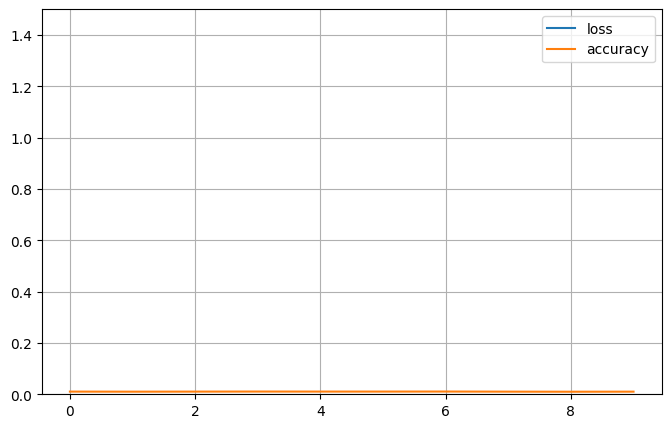

In [ ]:
plotHistory(history)

In [ ]:
print(f"Test accuracy: {simple_cnn_with_cbam.evaluate(ds_test)[1]}")

AttributeError: 'function' object has no attribute 'evaluate'

In [ ]:
pip install tf-explain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 729.6 kB/s eta 0:00:00


In [ ]:
from tf_explain.core.grad_cam import GradCAM

In [ ]:
explainer = GradCAM()

In [ ]:
for images, labels in tfds.as_numpy(ds_test.take(1)):
    X_test = images
    y_test = labels

In [ ]:
print(X_test.shape, y_test.shape)

(32, 32, 32, 3) (32,)


AttributeError: 'function' object has no attribute 'predict'

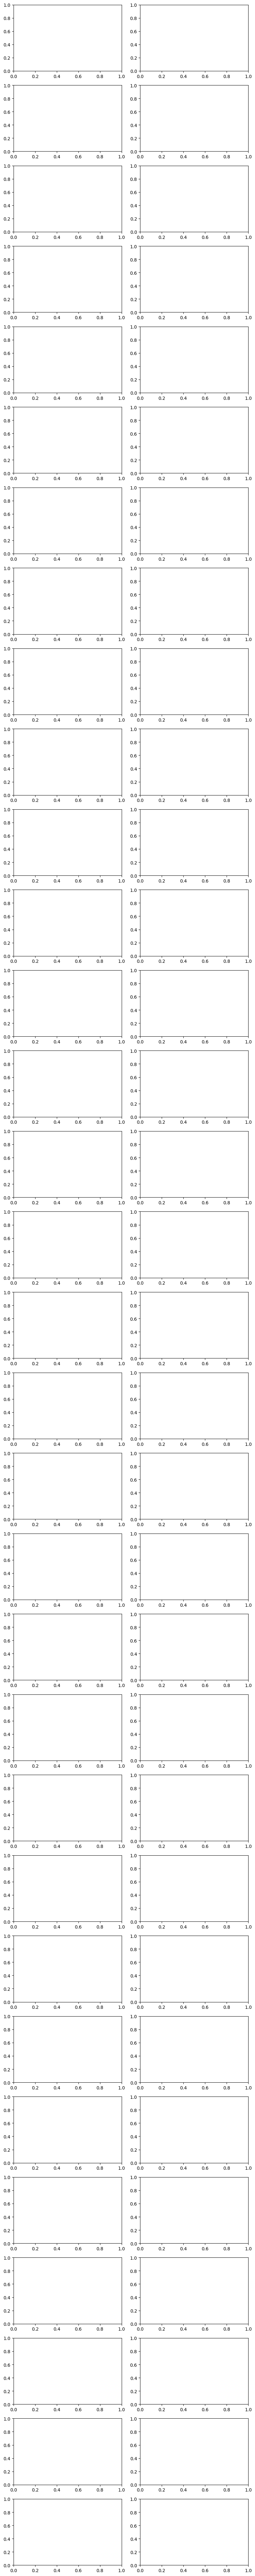

In [ ]:
fig, axes = plt.subplots(32, 2, figsize=(8,80))
fig.tight_layout()
index = 0
for img, label in zip(X_test, y_test):
    explainGradCam(explainer, axes[index], img,
               label,
               simple_cnn_no_attention,
               simple_cnn_no_attention.predict(img[None]),
               simple_cnn_with_cbam,
               simple_cnn_with_cbam.predict(img[None]),
               class_names=ds_info.features['label'].names)
    index += 1